In [1]:
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_eeg_files_with_label(session_number, subject_id, desired_label):
    base_dir = r"D:\code\sepide\codes\data\seed-iv\output_csv"
    session_name = "session" + str(session_number)
    # Convert subject_id to string if needed
    subject_str = str(subject_id)

    # Build the subject folder path
    subject_dir = os.path.join(base_dir, session_name, subject_str)

    # Collect all CSV files in this subject's folder
    csv_pattern = os.path.join(subject_dir, "*.csv")
    all_csv_files = sorted(glob.glob(csv_pattern))

    # We will look for filenames of the form: SOMETXT_eeg<number>_<label>.csv
    # Example: cz_eeg1_2.csv means the EEG number is 1, label is 2.
    # We'll parse these with a regular expression.
    regex = re.compile(r"(.*_eeg)(\d+)_(\d+)\.csv")

    matched_files = []

    for csv_file in all_csv_files:
        filename = os.path.basename(csv_file)

        match = regex.match(filename)
        if match:
            # Extract the eeg number and label from the filename
            eeg_number = int(match.group(2))  # e.g. 1
            file_label = int(match.group(3))  # e.g. 2

            # Check if this file has the desired label
            if file_label == desired_label:
                matched_files.append((csv_file, eeg_number))

    # Sort the matched files by the EEG number
    matched_files.sort(key=lambda x: x[1])

    # Read and store data in a list of DataFrames
    dataframes = []
    for csv_file, eeg_number in matched_files:
        df = pd.read_csv(csv_file, header=None)
        dataframes.append(df)

    desired_columns = [14, 22, 23, 24, 30, 31, 32, 33, 39, 40, 41, 49]
    df_filtered = df.iloc[:, desired_columns]
    new_column_names = [f"Ch{col_idx}" for col_idx in desired_columns]
    df_filtered.columns = new_column_names

    return df_filtered

In [3]:
# SICE
import numpy as np
from sklearn.preprocessing import normalize


def normr(a, replace_zero_rows=True):
    a = normalize(a, axis=1, norm="l2")
    if replace_zero_rows:
        for i in range(a.shape[0]):
            if np.sum(np.abs(a[i, :])) == 0:
                a[i, :] = 1 / np.sqrt(a.shape[1])
    return a


def window_moving(data_without_target, window_size, shift):

    n = len(data_without_target)
    win_index_dic = []
    start_id = 0

    while True:
        end_id = start_id + window_size

        # Stop if this window would go past the end of the DataFrame
        if end_id > n:
            break

        # Record this full window
        window = {
            "start_index": start_id,
            "end_index": end_id - 1,  # end index is inclusive
        }
        win_index_dic.append(window)

        # Move forward by 'shift'
        start_id += shift

        # If we've moved beyond the dataset, we're done
        if start_id >= n:
            break

    num_windows = len(win_index_dic)
    return win_index_dic, num_windows


def cosine_sim(data_without_target, windows, num_windows):
    """
    input:
    data_without_target = pandas dataset without target column
    windows = list of dictionaries which contain start and end index of each window in order
    num_windows = total number of segments
    output:
    sim :i-th frontal slice of sim tensor is a similarity matrix of i-th window's features
    """
    sim = np.zeros(
        (data_without_target.shape[1], data_without_target.shape[1], num_windows)
    )
    for i in range(num_windows):
        segmented_window = data_without_target.iloc[
            windows[i]["start_index"] : windows[i]["end_index"] + 1, :
        ].T.to_numpy()
        temp = normr(segmented_window)
        cos_matrix = np.abs(temp.dot(temp.T))
        # cos_matrix=cosine_similarity(segmented_window,dense_output=False)
        sim[:, :, i] = cos_matrix - np.diag(np.diag(cos_matrix))
    return sim


def buildHistogram(matrix):
    plt.hist(matrix, bins=30)
    plt.show()


def H_matrix(sim):
    """
    input:
    sim :i-th frontal slice of tensor is a similarity matrix of i-th window's features
    output:
    H =  the second order correlation matrix ( of [i,j,:] fibers similarity)
    from feature similarity tensor"""

    [n1, n2, n3] = sim.shape
    feature_similarity_matrix = sim.reshape(n1 * n2, n3)
    temp = normr(feature_similarity_matrix, False)

    cos_matrix = np.abs(temp.dot(temp.T))
    Q = cos_matrix - np.diag(np.diag(cos_matrix))
    T = np.zeros(Q.shape)
    T[:, np.sum(np.abs(Q), 0) == 0] = 1 / Q.shape[0]
    Q = Q + T
    Q = normalize(Q, axis=0, norm="l1")
    return Q


def page_rank_vec(sim):
    """
    Computes the PageRank vector using the power iteration method.

    Args:
    sim (numpy.ndarray): Similarity matrix.
    tol (float): Tolerance for convergence.
    alpha (float): Damping factor.
    max_iter (int): Maximum number of iterations.

    Returns:
    numpy.ndarray: PageRank vector.
    """
    max_iter = 1000
    tol = 10**-7
    alpha = 0.85
    Q = H_matrix(sim)
    n = Q.shape[0]
    e = np.ones((n, 1))
    A = alpha * Q + (1 - alpha) / n * (e.dot(e.T))

    pr = np.ones(n) / n  # Initial PageRank vector
    for _ in range(max_iter):
        pr_new = A.dot(pr)
        pr_new /= np.sum(pr_new)  # Normalize the PageRank vector
        if np.linalg.norm(pr_new - pr, 1) < tol:
            break
        pr = pr_new

    return pr


def page_rank_to_weight_matrix_seed_iv(pr):
    # pr[pr<np.mean(pr)]=0
    number_of_feature = int(np.sqrt(len(pr)))
    pr_reshaped = pr.reshape(number_of_feature, number_of_feature)
    return pr_reshaped


def weight_matrix_seed_iv(data_without_target, window_size, shift):
    win_index_dic, num_windows = window_moving(data_without_target, window_size, shift)
    feature_similarity_tensor = cosine_sim(
        data_without_target, win_index_dic, num_windows
    )  # sim
    page_rank_vector = page_rank_vec(feature_similarity_tensor)
    pr_reshaped = page_rank_to_weight_matrix_seed_iv(page_rank_vector)
    return pr_reshaped

In [4]:
def plot_weight_histogram(weight_matrix, bins=50):

    # Convert to NumPy array if needed
    weights = np.array(weight_matrix).flatten()

    # Create the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(weights, bins=bins, color="blue", alpha=0.7, edgecolor="black")

    plt.title("Distribution of Weight Matrix Values")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)

    # Show the histogram
    plt.show()

In [5]:
def truncate_df_to_full_windows(df, window_size=800, shift=200):

    n = len(df)

    # If there's not enough rows for even one full window, return empty
    if n < window_size:
        return df.iloc[0:0]  # empty DataFrame with same columns

    last_full_end = ((n - window_size) // shift) * shift + window_size

    # Safety check: if last_full_end is non-positive, return empty
    if last_full_end <= 0:
        return df.iloc[0:0]

    # Return a truncated DataFrame from the start up to 'last_full_end' rows
    truncated_df = df.iloc[:last_full_end]
    return truncated_df

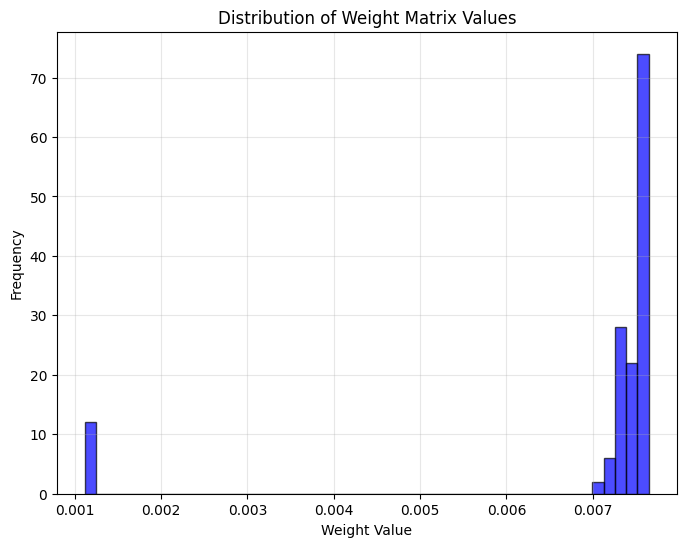

Saved weight matrix for subject 1 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_1.csv


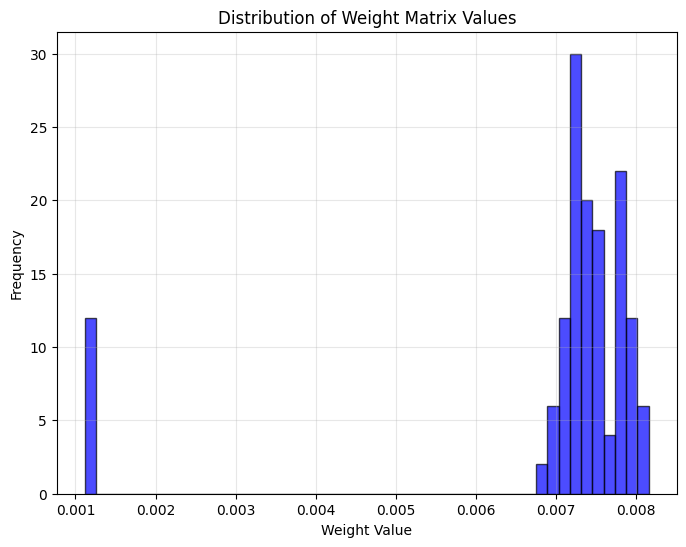

Saved weight matrix for subject 2 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_2.csv


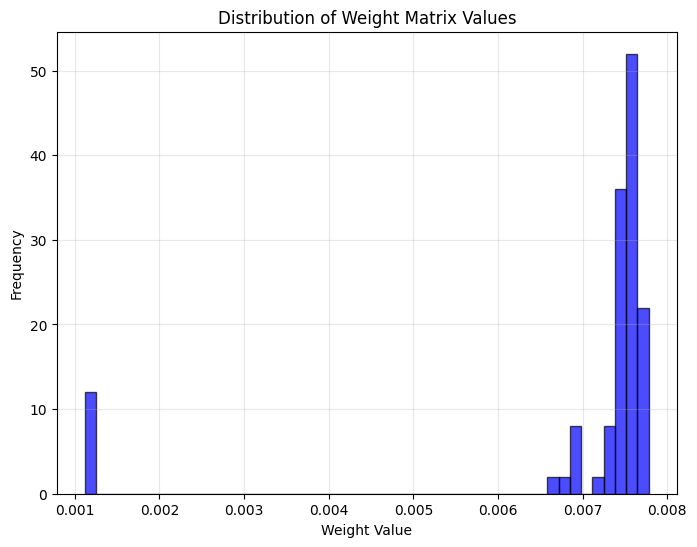

Saved weight matrix for subject 3 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_3.csv


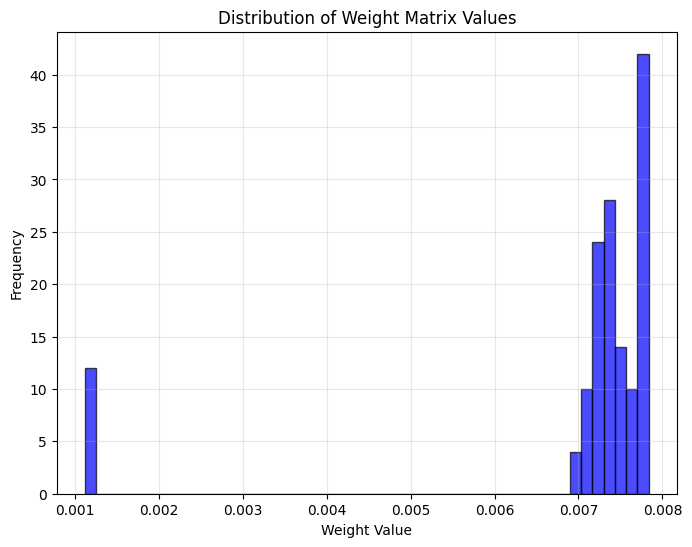

Saved weight matrix for subject 4 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_4.csv


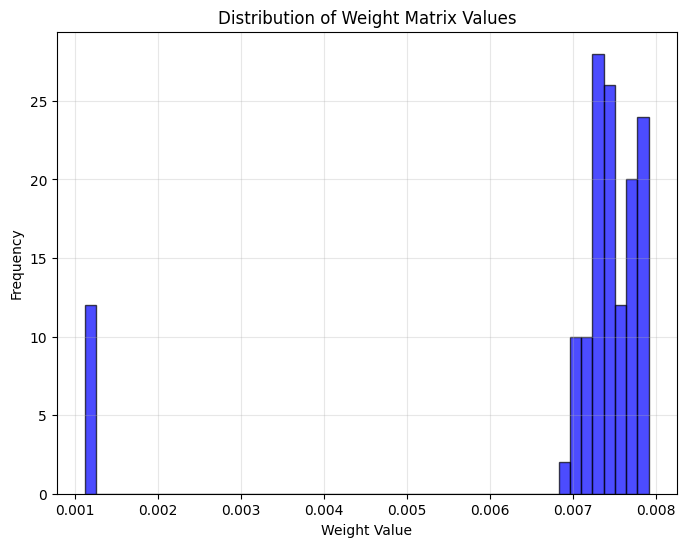

Saved weight matrix for subject 5 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_5.csv


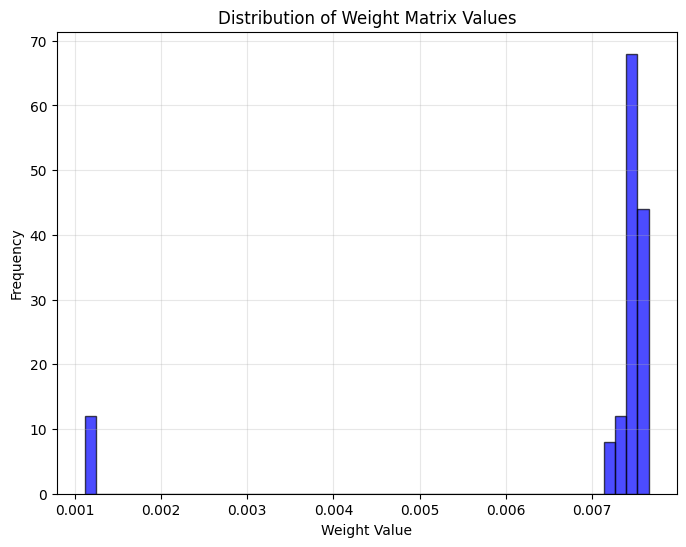

Saved weight matrix for subject 6 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_6.csv


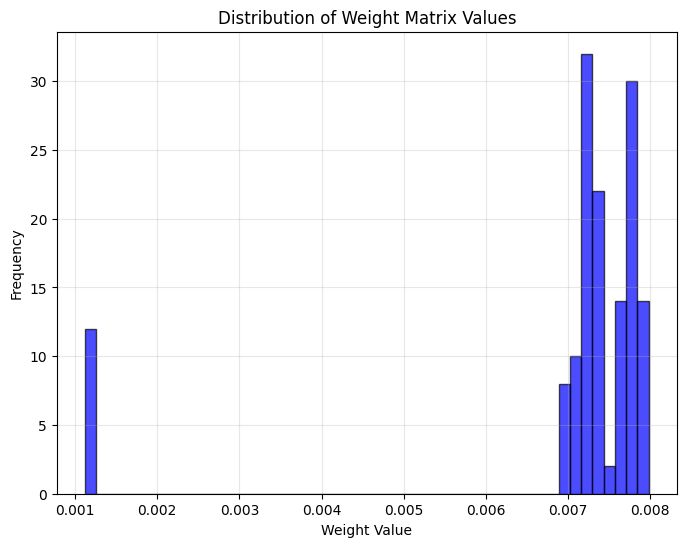

Saved weight matrix for subject 7 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_7.csv


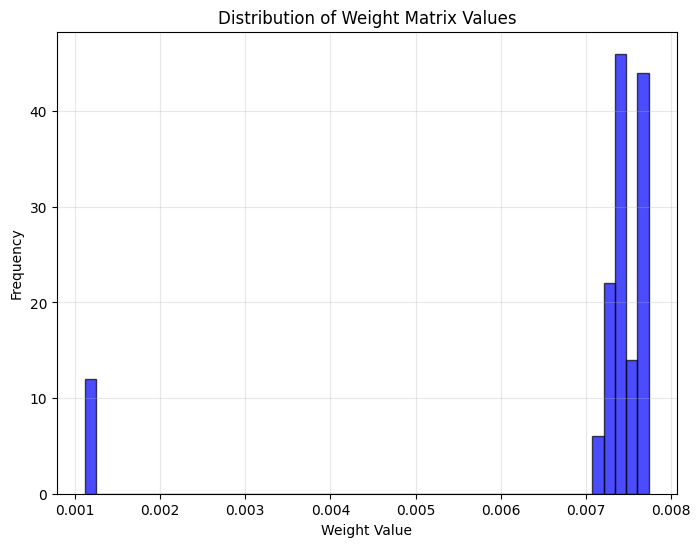

Saved weight matrix for subject 8 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_8.csv


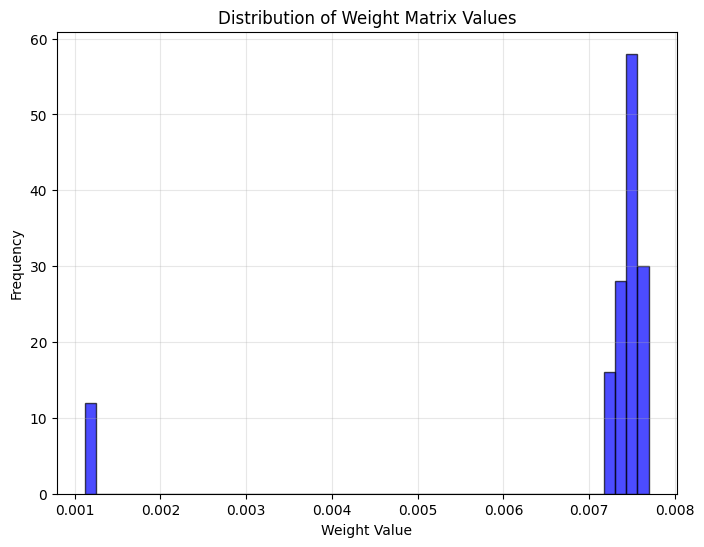

Saved weight matrix for subject 9 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_9.csv


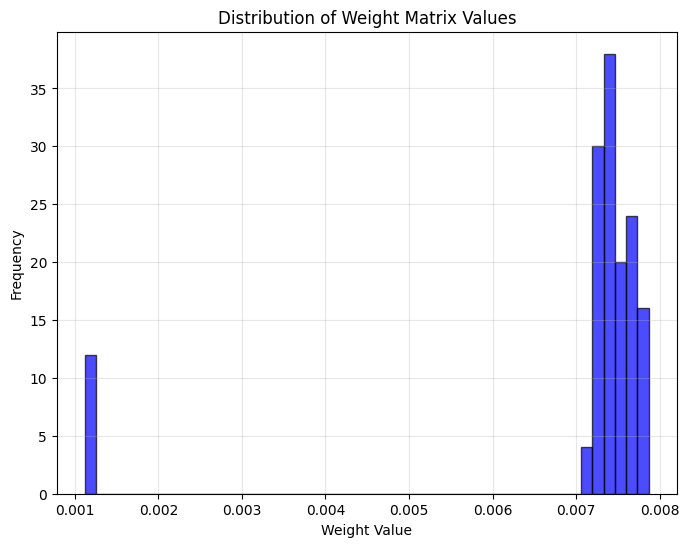

Saved weight matrix for subject 10 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_10.csv


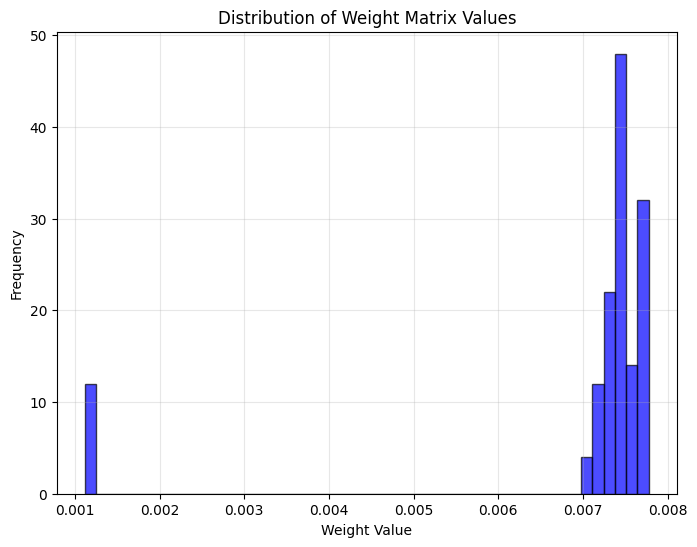

Saved weight matrix for subject 11 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_11.csv


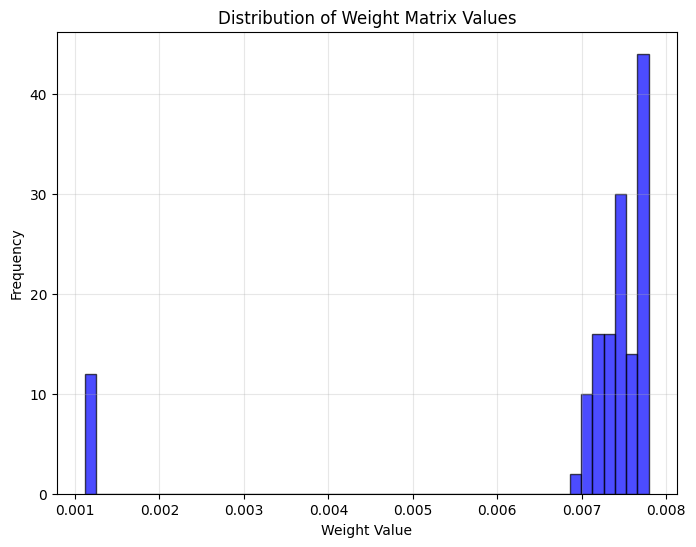

Saved weight matrix for subject 12 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_12.csv


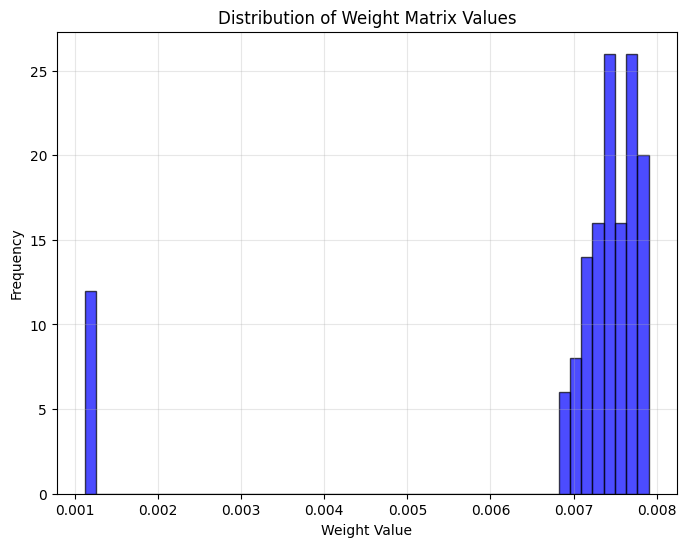

Saved weight matrix for subject 13 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_13.csv


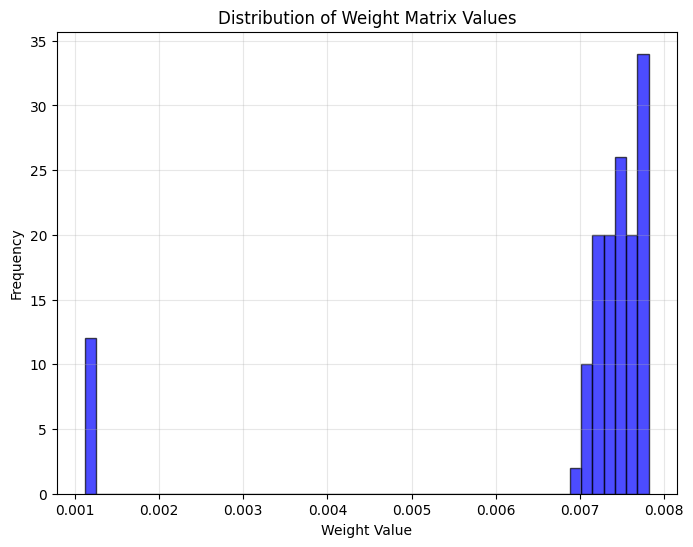

Saved weight matrix for subject 14 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_14.csv


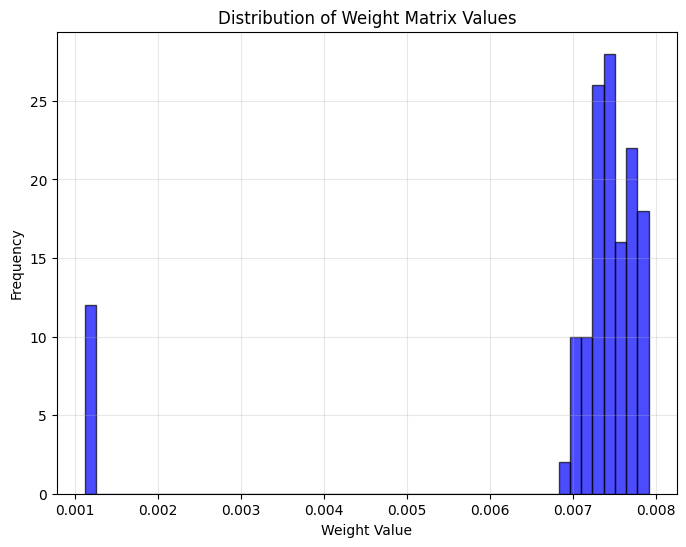

Saved weight matrix for subject 15 to D:\code\sepide\codes\experiments\seed-iv-weight-matrix\weight_matrix_subject_15.csv


In [6]:
import os
import pandas as pd

# Make sure these functions exist/imported:
#   get_eeg_files_with_label(...)
#   truncate_df_to_full_windows(...)
#   weight_matrix_seed_iv(...)

window_size = 800
shift = 200
output_dir = r"D:\code\sepide\codes\experiments\seed-iv-weight-matrix"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

for i in range(1, 16):
    # 1. Retrieve and truncate data for session 1
    dataset_1 = get_eeg_files_with_label(
        session_number=1, subject_id=i, desired_label=1
    )
    truncated_dataset_1 = truncate_df_to_full_windows(dataset_1, window_size, shift)

    # 2. Retrieve and truncate data for session 2
    dataset_2 = get_eeg_files_with_label(
        session_number=2, subject_id=i, desired_label=1
    )
    truncated_dataset_2 = truncate_df_to_full_windows(dataset_2, window_size, shift)

    # 3. Retrieve and truncate data for session 3
    dataset_3 = get_eeg_files_with_label(
        session_number=3, subject_id=i, desired_label=1
    )
    truncated_dataset_3 = truncate_df_to_full_windows(dataset_3, window_size, shift)

    # 4. Concatenate data from all three sessions
    dataset = pd.concat(
        [truncated_dataset_1, truncated_dataset_2, truncated_dataset_3], axis=0
    )

    # 5. Generate a weight matrix (NumPy array) for the combined dataset
    weight_matrix = weight_matrix_seed_iv(dataset, window_size, shift)
    plot_weight_histogram(weight_matrix, bins=50)

    # 6. Convert the weight matrix to a DataFrame
    df_weight_matrix = pd.DataFrame(weight_matrix)

    # 7. Construct the output CSV filename for the current subject
    csv_filename = f"weight_matrix_subject_{i}.csv"
    csv_path = os.path.join(output_dir, csv_filename)

    # 8. Save the DataFrame to CSV (no headers, no index)
    df_weight_matrix.to_csv(csv_path, header=False, index=False)

    print(f"Saved weight matrix for subject {i} to {csv_path}")

In [7]:
weight_matrix.shape

(12, 12)

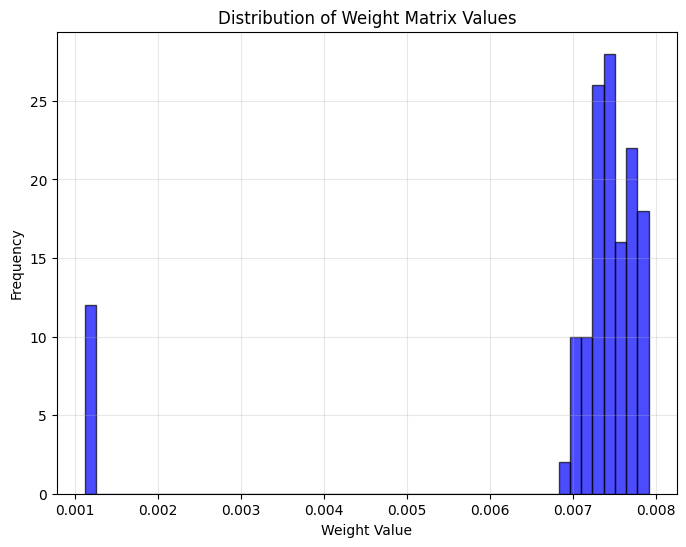

In [8]:
plot_weight_histogram(weight_matrix, bins=50)